# Find the best neighborhood in Madrid to open a Restaurant

### 1. Introduction
  


Madrid is the capital and the most populated city in Spain. The city has almost 3.3 million inhabitants and a metropolitan area population of approximately 6.5 million. It concentrates activities directly related to power and to knowledge and technological innovation. It is one of the largest financial centers in Europe and the largest in Spain.

  * **Bussines Poblem**
  
Madrid is administratively divided into 21 districts, which in turn are subdivided into 131 neighborhoods. 

Are there differences from one district to another? How are businesses distributed in each of your districts? Where would it be more prosperous to open a new restaurant?

In this analysis we will try to find an optimal location for a restaurant in Madrid taking into account the competitors and which group of people with income will be attracted according to the population of the neighborhood. To do this we will use an unsupervised automatic learning algorithm (K-Means) and will take into account demographic data, per capita income by district and housing prices.


### 2. Data acquisition

Based on the definition of our problem. The necessary data sources have been obtained from:

- **Foursquare API**: Collection of restaurant related data (location, distribution, type of food)

- **National Institute of Statistics (INE)**: Official site for downloading demographic data, per capita income and housing prices.

- **Madrid City Council open data portal**: Official site for downloading data related to Madrid.

### 3. Methodology


#### Importing the necessary libraries

In [36]:
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner

import requests # library to handle requests

import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans


#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values


#### Exploring data

In [37]:
# Boroughs and Neighborhoods from Madrid
df = pd.read_csv('barrios_municipio_madrid.csv',sep= ';', encoding='Latin 1')
df.head()

,barrio_codigo,barrio_nombre,distrito_codigo,distrito_nombre,municipio_codigo,municipio_nombre,superficie_km2,densidad_por_km2
0,796011,Palacio,79601,Centro,796,Madrid,1.46,15323.29
1,796012,Embajadores,79601,Centro,796,Madrid,1.03,43345.63
2,796013,Cortes,79601,Centro,796,Madrid,0.59,17850.85
3,796014,Justicia,79601,Centro,796,Madrid,0.75,21866.67
4,796015,Universidad,79601,Centro,796,Madrid,0.93,33051.61


In [38]:
df.columns

Index(['barrio_codigo', 'barrio_nombre', 'distrito_codigo', 'distrito_nombre',
       'municipio_codigo', 'municipio_nombre', 'superficie_km2',
       'densidad_por_km2'],
      dtype='object')

In [39]:
df.shape

(128, 8)

In [40]:
# Extracting the necessary columns 
dfm=df.groupby(['distrito_codigo','distrito_nombre']).agg(','.join)
dfm.reset_index(inplace=True)
dfm.drop(['municipio_nombre'], axis=1, inplace=True)
dfm

,distrito_codigo,distrito_nombre,barrio_nombre
0,79601,Centro,"Palacio, Embajadores, Co..."
1,79602,Arganzuela,"Imperial, Las Acacias, L..."
2,79603,Retiro,"Pacífico, Adelfas, Estre..."
3,79604,Salamanca,"Recoletos, Goya, Fuente ..."
4,79605,Chamartín,"El Viso, Prosperidad, Ci..."
5,79606,Tetuan,"Bellas Vistas, Cuatro Caminos, ..."
6,79607,Chamberí,"Gaztambide, Arapiles, Tr..."
7,79608,Fuencarral-El Pardo,"El Pardo, Fuentelarreina, ..."
8,79609,Moncloa-Aravaca,"Casa de Campo, Argüelles, ..."
9,79610,Latina,"Los Cármenes, Puerta del Angel,..."


In [41]:
dfm.shape

(21, 3)

In [42]:
# Population by borough
df2 = pd.read_csv('poblacion_distritos.csv',sep= ';')
df2.head()

,Distrito,Superficie (Ha),Densidad (hab./Ha),Población a 1-1-2020
0,Centro,"522,82","268,68",140.473
1,Arganzuela,"646,22",241,155.660
2,Retiro,"546,62",220,120.406
3,Salamanca,"539,24",274,147.854
4,Chamartín,"917,55",161,147.551


In [43]:
# Per capita income  and housing prices by borough
pv=pd.read_excel('precio_vivienda.xls', sheet_name=0)
pv

,Distrito,Nov_20,Oct_20,Sep_20,Ago_20,Jul_20,Jun_20,May_20,Abr_20,Mar_20,...,Sep_19,Ago_19,Jul_19,Jun_19,May_19,Abr_19,Mar_19,Feb_19,Ene_19,Renta_INE
0,Centro,4878,4909,4934,4963,4981,5061,5075,5062,5026,...,4994,4993,5044,5031,4991,5034,5069,5033,4987,16147
1,Arganzuela,3917,3908,3915,3912,3910,3948,3962,3903,3878,...,4059,4073,4096,4085,4080,4095,4071,4042,4017,17306
2,Retiro,3917,3908,3915,3912,4513,4564,4586,4560,4555,...,4572,4575,4598,4660,4669,4637,4631,4614,4529,21504
3,Salamanca,4520,5808,5826,5833,5903,5986,3962,3903,4555,...,5788,5791,5860,5868,5848,5850,5818,5829,5752,24433
4,Chamartín,5018,5040,5056,5068,5109,5180,5179,5143,5118,...,4980,4931,4941,4934,5051,5102,5174,5196,5187,25969
5,Tetuán,5018,5040,5056,3669,3682,3696,3679,3714,3725,...,3716,3719,3702,3719,3722,3731,3725,3693,3644,14970
6,Chamberí,5288,5334,5374,5329,5337,5419,5432,5426,5386,...,5331,5347,5309,5271,5287,5276,5249,5253,5285,22499
7,Fuencarral-El Pardo,3917,3908,3915,3912,4513,5986,3573,3570,3530,...,3480,3447,3436,3369,3402,3418,3379,3364,3374,18573
8,Moncloa-Aravaca,3893,3877,3913,3905,3910,3913,3898,3932,3939,...,3896,3910,3931,3928,3950,3905,3892,3875,3854,22152
9,Latina,2246,2246,2254,2269,2310,2330,2330,2364,2341,...,2292,2293,2276,2292,2290,2291,2280,2305,2303,12232


In [44]:
pv['AvgHousingPrice']=pv.mean(axis=1)
pv

,Distrito,Nov_20,Oct_20,Sep_20,Ago_20,Jul_20,Jun_20,May_20,Abr_20,Mar_20,...,Ago_19,Jul_19,Jun_19,May_19,Abr_19,Mar_19,Feb_19,Ene_19,Renta_INE,AvgHousingPrice
0,Centro,4878,4909,4934,4963,4981,5061,5075,5062,5026,...,4993,5044,5031,4991,5034,5069,5033,4987,16147,5479.500000
1,Arganzuela,3917,3908,3915,3912,3910,3948,3962,3903,3878,...,4073,4096,4085,4080,4095,4071,4042,4017,17306,4547.750000
2,Retiro,3917,3908,3915,3912,4513,4564,4586,4560,4555,...,4575,4598,4660,4669,4637,4631,4614,4529,21504,5178.416667
3,Salamanca,4520,5808,5826,5833,5903,5986,3962,3903,4555,...,5791,5860,5868,5848,5850,5818,5829,5752,24433,6352.916667
4,Chamartín,5018,5040,5056,5068,5109,5180,5179,5143,5118,...,4931,4941,4934,5051,5102,5174,5196,5187,25969,5944.666667
5,Tetuán,5018,5040,5056,3669,3682,3696,3679,3714,3725,...,3719,3702,3719,3722,3731,3725,3693,3644,14970,4333.708333
6,Chamberí,5288,5334,5374,5329,5337,5419,5432,5426,5386,...,5347,5309,5271,5287,5276,5249,5253,5285,22499,6040.750000
7,Fuencarral-El Pardo,3917,3908,3915,3912,4513,5986,3573,3570,3530,...,3447,3436,3369,3402,3418,3379,3364,3374,18573,4322.333333
8,Moncloa-Aravaca,3893,3877,3913,3905,3910,3913,3898,3932,3939,...,3910,3931,3928,3950,3905,3892,3875,3854,22152,4676.958333
9,Latina,2246,2246,2254,2269,2310,2330,2330,2364,2341,...,2293,2276,2292,2290,2291,2280,2305,2303,12232,2711.583333


In [45]:
pv.columns

Index(['Distrito', 'Nov_20', 'Oct_20', 'Sep_20', 'Ago_20', 'Jul_20', 'Jun_20',
       'May_20', 'Abr_20', 'Mar_20', 'Feb_20', 'Ene_20', 'Unnamed: 12',
       'Dic_19', 'Nov_19', 'Oct_19', 'Sep_19', 'Ago_19', 'Jul_19', 'Jun_19',
       'May_19', 'Abr_19', 'Mar_19', 'Feb_19', 'Ene_19', 'Renta_INE',
       'AvgHousingPrice'],
      dtype='object')

In [46]:
renta=pv[['Distrito','Renta_INE','AvgHousingPrice']]
renta

,Distrito,Renta_INE,AvgHousingPrice
0,Centro,16147,5479.500000
1,Arganzuela,17306,4547.750000
2,Retiro,21504,5178.416667
3,Salamanca,24433,6352.916667
4,Chamartín,25969,5944.666667
5,Tetuán,14970,4333.708333
6,Chamberí,22499,6040.750000
7,Fuencarral-El Pardo,18573,4322.333333
8,Moncloa-Aravaca,22152,4676.958333
9,Latina,12232,2711.583333


In [47]:
# Formato poblacion
#df2.style.format("{:.2f}")

In [48]:
# Merging in a single dataset
md = dfm.join(df2['Población a 1-1-2020'])
md

,distrito_codigo,distrito_nombre,barrio_nombre,Población a 1-1-2020
0,79601,Centro,"Palacio, Embajadores, Co...",140.473
1,79602,Arganzuela,"Imperial, Las Acacias, L...",155.660
2,79603,Retiro,"Pacífico, Adelfas, Estre...",120.406
3,79604,Salamanca,"Recoletos, Goya, Fuente ...",147.854
4,79605,Chamartín,"El Viso, Prosperidad, Ci...",147.551
5,79606,Tetuan,"Bellas Vistas, Cuatro Caminos, ...",161.313
6,79607,Chamberí,"Gaztambide, Arapiles, Tr...",140.866
7,79608,Fuencarral-El Pardo,"El Pardo, Fuentelarreina, ...",249.973
8,79609,Moncloa-Aravaca,"Casa de Campo, Argüelles, ...",121.683
9,79610,Latina,"Los Cármenes, Puerta del Angel,...",242.139


In [49]:
md2 = md.join(renta)
md2.drop('Distrito', axis=1, inplace=True)
md2

,distrito_codigo,distrito_nombre,barrio_nombre,Población a 1-1-2020,Renta_INE,AvgHousingPrice
0,79601,Centro,"Palacio, Embajadores, Co...",140.473,16147,5479.500000
1,79602,Arganzuela,"Imperial, Las Acacias, L...",155.660,17306,4547.750000
2,79603,Retiro,"Pacífico, Adelfas, Estre...",120.406,21504,5178.416667
3,79604,Salamanca,"Recoletos, Goya, Fuente ...",147.854,24433,6352.916667
4,79605,Chamartín,"El Viso, Prosperidad, Ci...",147.551,25969,5944.666667
5,79606,Tetuan,"Bellas Vistas, Cuatro Caminos, ...",161.313,14970,4333.708333
6,79607,Chamberí,"Gaztambide, Arapiles, Tr...",140.866,22499,6040.750000
7,79608,Fuencarral-El Pardo,"El Pardo, Fuentelarreina, ...",249.973,18573,4322.333333
8,79609,Moncloa-Aravaca,"Casa de Campo, Argüelles, ...",121.683,22152,4676.958333
9,79610,Latina,"Los Cármenes, Puerta del Angel,...",242.139,12232,2711.583333


In [50]:
md2.shape

(21, 6)

In [51]:
# Renaming the columns
md2.rename(columns={'distrito_codigo': 'Postcode', 'distrito_nombre':'Borough','barrio_nombre':'Neighborhood','Población a 1-1-2020':'Population', 'Renta_INE':'RentaINE'}, inplace=True)
md2

,Postcode,Borough,Neighborhood,Population,RentaINE,AvgHousingPrice
0,79601,Centro,"Palacio, Embajadores, Co...",140.473,16147,5479.500000
1,79602,Arganzuela,"Imperial, Las Acacias, L...",155.660,17306,4547.750000
2,79603,Retiro,"Pacífico, Adelfas, Estre...",120.406,21504,5178.416667
3,79604,Salamanca,"Recoletos, Goya, Fuente ...",147.854,24433,6352.916667
4,79605,Chamartín,"El Viso, Prosperidad, Ci...",147.551,25969,5944.666667
5,79606,Tetuan,"Bellas Vistas, Cuatro Caminos, ...",161.313,14970,4333.708333
6,79607,Chamberí,"Gaztambide, Arapiles, Tr...",140.866,22499,6040.750000
7,79608,Fuencarral-El Pardo,"El Pardo, Fuentelarreina, ...",249.973,18573,4322.333333
8,79609,Moncloa-Aravaca,"Casa de Campo, Argüelles, ...",121.683,22152,4676.958333
9,79610,Latina,"Los Cármenes, Puerta del Angel,...",242.139,12232,2711.583333


In [52]:
md3=md2.loc[:,['Borough','Population']]
md3.to_csv('madrid.csv')

In [53]:
md2.describe()

,Postcode,Population,RentaINE,AvgHousingPrice
count,21.000000,21.000000,21.000000,21.000000
mean,79611.000000,158.796667,16078.428571,3882.521825
std,6.204837,57.538604,5046.096229,1364.257435
min,79601.000000,50.010000,9395.000000,2049.583333
25%,79606.000000,121.683000,11925.000000,2702.416667
50%,79611.000000,147.854000,15408.000000,3770.916667
75%,79616.000000,193.264000,18573.000000,4676.958333
max,79621.000000,260.196000,25969.000000,6352.916667


In [54]:
#Visualizing 

In [55]:
data = md2.groupby('Borough')['Population'].sum()

In [56]:
data_per = data.groupby('Borough').agg(percentage =('Population', lambda p: p.sum() / data.sum() * 100)).round(2)

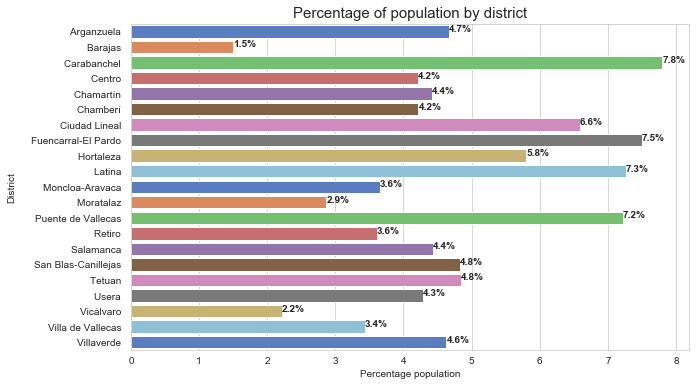

In [57]:

sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x="percentage", y=data_per.index, data=data_per, ci=None, palette="muted",orient='h' )
ax.set_title("Percentage of population by district", fontsize=15)
ax.set_xlabel ("Percentage population")
ax.set_ylabel ("District")
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width(), weight='bold' )
bar.savefig("Seaborn_Bar_Vertical.png");

In [58]:
data2 = md2.groupby('Borough')['RentaINE'].sum()
data_per2 = data2.groupby('Borough').agg(percentage =('RentaINE', lambda p: p.sum() / data2.sum() * 100)).round(2)

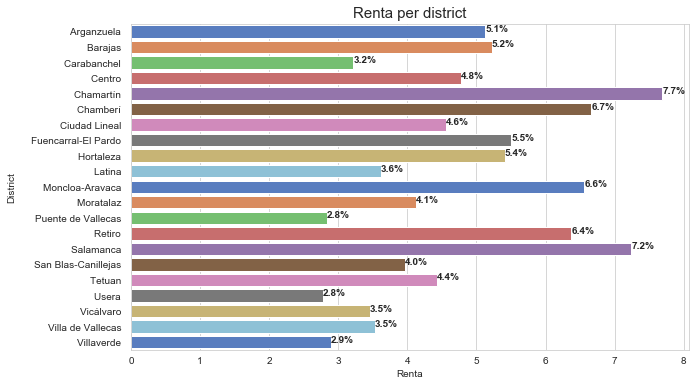

In [59]:
sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x="percentage", y=data_per2.index, data=data_per2, ci=None, palette="muted",orient='h' )
ax.set_title("Renta per district", fontsize=15)
ax.set_xlabel ("Renta")
ax.set_ylabel ("District")
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width(), weight='bold' )

In [60]:
data3 = md2.groupby('Borough')['AvgHousingPrice'].sum()
data_per3 = data3.groupby('Borough').agg(percentage =('AvgHousingPrice', lambda p: p.sum() / data3.sum() * 100)).round(2)

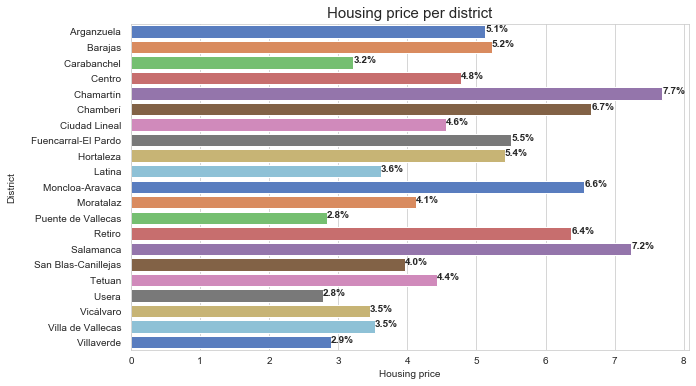

In [61]:
sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x="percentage", y=data_per3.index, data=data_per2, ci=None, palette="muted",orient='h' )
ax.set_title("Housing price per district", fontsize=15)
ax.set_xlabel ("Housing price")
ax.set_ylabel ("District")
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width(), weight='bold' )

In [62]:
# Getting latitude and longitude data for each borough in a new dataset
dist_name= md2['Borough'].tolist()
columns=['Borough','Latitude','Longitude']
columns

['Borough', 'Latitude', 'Longitude']

In [63]:
dist_name= md2['Borough'].tolist()
columns=['Borough','Latitude','Longitude']
lat_lng=pd.DataFrame(columns=columns)
for borough in dist_name:
    locator=Nominatim(user_agent= 'init')
    location=locator.geocode('{}, Madrid, Spain'.format(borough))
    lat=location.latitude
    lng=location.longitude
    print('Borough = {}, Latitude = {}, Longitude = {}'.format(borough,location.latitude, location.longitude))
    lat_lng=lat_lng.append({'Borough': borough, 'Latitude': lat,'Longitude':lng},ignore_index=True)
lat_lng    

Borough =     Centro , Latitude = 40.417652700000005, Longitude = -3.7079137662915533
Borough =     Arganzuela , Latitude = 40.39806845, Longitude = -3.6937339526567428
Borough =     Retiro , Latitude = 40.4111495, Longitude = -3.6760566
Borough =     Salamanca , Latitude = 40.4270451, Longitude = -3.6806024
Borough =     Chamartín , Latitude = 40.4589872, Longitude = -3.6761288
Borough =     Tetuan , Latitude = 40.4605781, Longitude = -3.6982806
Borough =     Chamberí , Latitude = 40.43624735, Longitude = -3.7038303534513837
Borough =     Fuencarral-El Pardo , Latitude = 40.55634555, Longitude = -3.7785905137518054
Borough =     Moncloa-Aravaca , Latitude = 40.43949485, Longitude = -3.7442035396547055
Borough =     Latina , Latitude = 40.4035317, Longitude = -3.736152
Borough =     Carabanchel , Latitude = 40.3742112, Longitude = -3.744676
Borough =     Usera , Latitude = 40.383894, Longitude = -3.7064459
Borough =     Puente de Vallecas , Latitude = 40.3835532, Longitude = -3.6545354

,Borough,Latitude,Longitude
0,Centro,40.417653,-3.707914
1,Arganzuela,40.398068,-3.693734
2,Retiro,40.411150,-3.676057
3,Salamanca,40.427045,-3.680602
4,Chamartín,40.458987,-3.676129
5,Tetuan,40.460578,-3.698281
6,Chamberí,40.436247,-3.703830
7,Fuencarral-El Pardo,40.556346,-3.778591
8,Moncloa-Aravaca,40.439495,-3.744204
9,Latina,40.403532,-3.736152


In [64]:
lat_lng.shape

(21, 3)

In [65]:
# Merging in a single dataset
madrid_data=pd.merge(md2,lat_lng, on='Borough')
madrid_data

,Postcode,Borough,Neighborhood,Population,RentaINE,AvgHousingPrice,Latitude,Longitude
0,79601,Centro,"Palacio, Embajadores, Co...",140.473,16147,5479.500000,40.417653,-3.707914
1,79602,Arganzuela,"Imperial, Las Acacias, L...",155.660,17306,4547.750000,40.398068,-3.693734
2,79603,Retiro,"Pacífico, Adelfas, Estre...",120.406,21504,5178.416667,40.411150,-3.676057
3,79604,Salamanca,"Recoletos, Goya, Fuente ...",147.854,24433,6352.916667,40.427045,-3.680602
4,79605,Chamartín,"El Viso, Prosperidad, Ci...",147.551,25969,5944.666667,40.458987,-3.676129
5,79606,Tetuan,"Bellas Vistas, Cuatro Caminos, ...",161.313,14970,4333.708333,40.460578,-3.698281
6,79607,Chamberí,"Gaztambide, Arapiles, Tr...",140.866,22499,6040.750000,40.436247,-3.703830
7,79608,Fuencarral-El Pardo,"El Pardo, Fuentelarreina, ...",249.973,18573,4322.333333,40.556346,-3.778591
8,79609,Moncloa-Aravaca,"Casa de Campo, Argüelles, ...",121.683,22152,4676.958333,40.439495,-3.744204
9,79610,Latina,"Los Cármenes, Puerta del Angel,...",242.139,12232,2711.583333,40.403532,-3.736152


##### Plotting all Borough

In [66]:
mad=locator.geocode('Madrid, Spain')
print((mad.latitude, mad.longitude))

(40.4167047, -3.7035825)


In [68]:
url = 'https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data'
madrid_geo = f'{url}/madrid-districts.geojson'

map_madrid = folium.Map(location=[40.4167047, -3.7035825], zoom_start=10)
map_madrid.choropleth(geo_data=madrid_geo,
                      name='choropleth',
                      data=madrid_data,
                      columns=['Borough','Population'],
                      key_on='feature.properties.name',
                      fill_color='YlOrRd',
                      fill_opacity=0.7,
                      line_opacity=0.2,
                      legend_name='Population')

# add markers to map
for lat, lng, borough, neighborhood in zip(madrid_data['Latitude'], madrid_data['Longitude'], madrid_data['Borough'], madrid_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_madrid)  
    
map_madrid

#### Using the Foursquare API to explore the bussines in each borough.

In [120]:
CLIENT_ID = 'UJSBYU5XYYBJNVVOAWZWRJ02ADL02UZDOWETIWSGQRRVEZ0L' # your Foursquare ID
CLIENT_SECRET = 'EVM4ZA4V3QCH0WJTSLKX45POE5LLLOO5WCVSOMSIVSGXT5NS' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 1000

In [121]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION,
            lat, 
            lng, 
            radius, 
            LIMIT)
            
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [122]:
madrid_venues = getNearbyVenues(names=madrid_data['Neighborhood'],
                                   latitudes=madrid_data['Latitude'],
                                   longitudes=madrid_data['Longitude']
                                  )

        Palacio,        Embajadores,        Cortes,        Justicia,        Universidad,        Sol
[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b464cb3f964a520f01c26e3', 'name': 'Plaza de Isabel II', 'location': {'address': 'Pl. Isabel II', 'lat': 40.41811399542555, 'lng': -3.709396616703088, 'labeledLatLngs': [{'label': 'display', 'lat': 40.41811399542555, 'lng': -3.709396616703088}], 'distance': 135, 'postalCode': '28013', 'cc': 'ES', 'neighborhood': 'Opera', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['Pl. Isabel II', '28013 Madrid Madrid', 'España']}, 'categories': [{'id': '4bf58dd8d48988d164941735', 'name': 'Plaza', 'pluralName': 'Plazas', 'shortName': 'Plaza', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/plaza_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4b

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '5235a4a911d2bfb62063de25', 'name': 'Mercado de Motores', 'location': {'address': 'P. de las Delicias, 61', 'lat': 40.399148967924575, 'lng': -3.6919777332175228, 'labeledLatLngs': [{'label': 'display', 'lat': 40.399148967924575, 'lng': -3.6919777332175228}], 'distance': 191, 'postalCode': '28045', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['P. de las Delicias, 61', '28045 Madrid Madrid', 'España']}, 'categories': [{'id': '4bf58dd8d48988d1f7941735', 'name': 'Flea Market', 'pluralName': 'Flea Markets', 'shortName': 'Flea Market', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/fleamarket_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-5235a4a911d2bfb62063de25-0'}, {'reasons': {'count': 0, 'items': [{'summary': 'This spot is 

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4e6276311838ad3d0eceb6c9', 'name': 'Jardines de Cecilio Rodríguez', 'location': {'address': 'Parque del Retiro', 'lat': 40.41271436961524, 'lng': -3.677826255610415, 'labeledLatLngs': [{'label': 'display', 'lat': 40.41271436961524, 'lng': -3.677826255610415}], 'distance': 229, 'postalCode': '28009', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['Parque del Retiro', '28009 Madrid Madrid', 'España']}, 'categories': [{'id': '4bf58dd8d48988d15a941735', 'name': 'Garden', 'pluralName': 'Gardens', 'shortName': 'Garden', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/garden_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4e6276311838ad3d0eceb6c9-0'}, {'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'ty

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '582762425d0a1a73ca56d187', 'name': 'Rawcoco Green Bar', 'location': {'address': 'C/ General Pardiñas, 21', 'crossStreet': 'C/ Hermosilla', 'lat': 40.4261322084992, 'lng': -3.678593865357075, 'labeledLatLngs': [{'label': 'display', 'lat': 40.4261322084992, 'lng': -3.678593865357075}], 'distance': 198, 'postalCode': '28001', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['C/ General Pardiñas, 21 (C/ Hermosilla)', '28001 Madrid Madrid', 'España']}, 'categories': [{'id': '4bf58dd8d48988d112941735', 'name': 'Juice Bar', 'pluralName': 'Juice Bars', 'shortName': 'Juice Bar', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/juicebar_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-582762425d0a1a73ca56d187-0'}, {'reasons': {'count': 0, 'i

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4adcda3ff964a520653e21e3', 'name': 'Mercado de Chamartín', 'location': {'address': 'C. Bolivia, 9', 'crossStreet': 'C. Potosí', 'lat': 40.457389365330826, 'lng': -3.678028943415633, 'labeledLatLngs': [{'label': 'display', 'lat': 40.457389365330826, 'lng': -3.678028943415633}], 'distance': 239, 'postalCode': '28016', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['C. Bolivia, 9 (C. Potosí)', '28016 Madrid Madrid', 'España']}, 'categories': [{'id': '50be8ee891d4fa8dcc7199a7', 'name': 'Market', 'pluralName': 'Markets', 'shortName': 'Market', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/market_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4adcda3ff964a520653e21e3-0'}, {'reasons': {'count': 0, 'items': [{'summary': 'This spot 

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4b56115df964a520b8fe27e3', 'name': 'Asador Donostiarra', 'location': {'address': 'C. Infanta Mercedes, 79', 'lat': 40.461761391322334, 'lng': -3.6959669945379012, 'labeledLatLngs': [{'label': 'display', 'lat': 40.461761391322334, 'lng': -3.6959669945379012}], 'distance': 236, 'postalCode': '28020', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['C. Infanta Mercedes, 79', '28020 Madrid Madrid', 'España']}, 'categories': [{'id': '4bf58dd8d48988d150941735', 'name': 'Spanish Restaurant', 'pluralName': 'Spanish Restaurants', 'shortName': 'Spanish', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/spanish_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4b56115df964a520b8fe27e3-0'}, {'reasons': {'count': 0, 'items': [{'summary': 'This 

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '59545ced9ec399706f6f76d3', 'name': 'Mercadona', 'location': {'address': 'Calle de Bravo Murillo 5', 'lat': 40.43436130091705, 'lng': -3.7045037137500922, 'labeledLatLngs': [{'label': 'display', 'lat': 40.43436130091705, 'lng': -3.7045037137500922}], 'distance': 217, 'postalCode': '28015', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['Calle de Bravo Murillo 5', '28015 Madrid Madrid', 'España']}, 'categories': [{'id': '52f2ab2ebcbc57f1066b8b46', 'name': 'Supermarket', 'pluralName': 'Supermarkets', 'shortName': 'Supermarket', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/food_grocery_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-59545ced9ec399706f6f76d3-0'}, {'reasons': {'count': 0, 'items': [{'summary': 'This spot is popul

[]
        Casa de Campo,        Argüelles,        Ciudad Universitaria,        Valdezarza,        Valdemarín,        El Plantío,        Aravaca
[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4ddcfa8ed22df171990a5af1', 'name': 'Club de Campo. Chalet Infantil', 'location': {'lat': 40.44149515793571, 'lng': -3.744947998616381, 'labeledLatLngs': [{'label': 'display', 'lat': 40.44149515793571, 'lng': -3.744947998616381}], 'distance': 231, 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['Madrid Madrid', 'España']}, 'categories': [{'id': '4bf58dd8d48988d163941735', 'name': 'Park', 'pluralName': 'Parks', 'shortName': 'Park', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/park_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4ddcfa8ed22df171990a5af1-0'}, {'reasons': {'coun

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4cab692714c337045872ea3b', 'name': 'El Rincón del Greco', 'location': {'address': 'Avenida de Nuestra Señora de Fátima, 98', 'lat': 40.37984820598649, 'lng': -3.7487899291840074, 'labeledLatLngs': [{'label': 'display', 'lat': 40.37984820598649, 'lng': -3.7487899291840074}], 'distance': 717, 'postalCode': '28047', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['Avenida de Nuestra Señora de Fátima, 98', '28047 Madrid Madrid', 'España']}, 'categories': [{'id': '4bf58dd8d48988d155941735', 'name': 'Gastropub', 'pluralName': 'Gastropubs', 'shortName': 'Gastropub', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/gastropub_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}, 'venuePage': {'id': '69228157'}}, 'referralId': 'e-0-4cab692714c337045872ea3b-0'}, {'r

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '5299f9fd498e6bae5838c8d3', 'name': 'La Fonda Colombiana', 'location': {'address': 'Calle Ferroviarios 27', 'lat': 40.385709, 'lng': -3.704868, 'labeledLatLngs': [{'label': 'display', 'lat': 40.385709, 'lng': -3.704868}], 'distance': 242, 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['Calle Ferroviarios 27', 'Madrid Madrid', 'España']}, 'categories': [{'id': '4bf58dd8d48988d1c4941735', 'name': 'Restaurant', 'pluralName': 'Restaurants', 'shortName': 'Restaurant', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/default_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-5299f9fd498e6bae5838c8d3-0'}, {'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'v

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4c50243e3a6f2d7f737b0c77', 'name': 'El Fogon de Paco', 'location': {'address': 'C. Villalobos, 20', 'crossStreet': 'C. de los Leoneses', 'lat': 40.38187103474134, 'lng': -3.6485095627790187, 'labeledLatLngs': [{'label': 'display', 'lat': 40.38187103474134, 'lng': -3.6485095627790187}], 'distance': 544, 'postalCode': '28018', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['C. Villalobos, 20 (C. de los Leoneses)', '28018 Madrid Madrid', 'España']}, 'categories': [{'id': '4bf58dd8d48988d150941735', 'name': 'Spanish Restaurant', 'pluralName': 'Spanish Restaurants', 'shortName': 'Spanish', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/spanish_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4c50243e3a6f2d7f737b0c77-0'}, {'reasons':

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '50de2fe2e4b0869e4f933910', 'name': 'The Irish Temple', 'location': {'address': 'Av. Moratalaz 125, posterior', 'lat': 40.406590587552664, 'lng': -3.6500270155640737, 'labeledLatLngs': [{'label': 'display', 'lat': 40.406590587552664, 'lng': -3.6500270155640737}], 'distance': 442, 'postalCode': '28030', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['Av. Moratalaz 125, posterior', '28030 Madrid Madrid', 'España']}, 'categories': [{'id': '4bf58dd8d48988d11b941735', 'name': 'Pub', 'pluralName': 'Pubs', 'shortName': 'Pub', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/nightlife/pub_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-50de2fe2e4b0869e4f933910-0'}, {'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type':

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4d3f29a305b8721e6073a437', 'name': "Los Quesos de l'Amelie", 'location': {'address': 'C. Torrecilla del Puerto 5', 'lat': 40.45103964379575, 'lng': -3.6496303954715135, 'labeledLatLngs': [{'label': 'display', 'lat': 40.45103964379575, 'lng': -3.6496303954715135}], 'distance': 299, 'postalCode': '28043', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['C. Torrecilla del Puerto 5', '28043 Madrid Madrid', 'España']}, 'categories': [{'id': '4bf58dd8d48988d155941735', 'name': 'Gastropub', 'pluralName': 'Gastropubs', 'shortName': 'Gastropub', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/gastropub_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}, 'venuePage': {'id': '158905543'}}, 'referralId': 'e-0-4d3f29a305b8721e6073a437-0'}, {'reasons': {'count': 0, 

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4ce3de03c36ba35d851e72f6', 'name': 'Sidrería Arturo', 'location': {'address': 'C/ Mar de Bering 9', 'crossStreet': 'Mar de Japón', 'lat': 40.473013600854074, 'lng': -3.6414654408837968, 'labeledLatLngs': [{'label': 'display', 'lat': 40.473013600854074, 'lng': -3.6414654408837968}], 'distance': 105, 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['C/ Mar de Bering 9 (Mar de Japón)', 'Madrid Madrid', 'España']}, 'categories': [{'id': '4bf58dd8d48988d150941735', 'name': 'Spanish Restaurant', 'pluralName': 'Spanish Restaurants', 'shortName': 'Spanish', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/spanish_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4ce3de03c36ba35d851e72f6-0'}, {'reasons': {'count': 0, 'items': [{'summary': 'T

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4c94f52f21c7199c4920147f', 'name': 'La Peña de Francia', 'location': {'address': 'Calle Alcocer, 23', 'crossStreet': 'Paseo de Talleres', 'lat': 40.349395343941836, 'lng': -3.6996102176440955, 'labeledLatLngs': [{'label': 'display', 'lat': 40.349395343941836, 'lng': -3.6996102176440955}], 'distance': 523, 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['Calle Alcocer, 23 (Paseo de Talleres)', 'Madrid Madrid', 'España']}, 'categories': [{'id': '4bf58dd8d48988d150941735', 'name': 'Spanish Restaurant', 'pluralName': 'Spanish Restaurants', 'shortName': 'Spanish', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/spanish_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4c94f52f21c7199c4920147f-0'}, {'reasons': {'count': 0, 'items': [{'s

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4ecfe38a8231b9ef87ef0081', 'name': 'AhorraMas', 'location': {'address': 'Av. de la  Gavia, 48', 'lat': 40.37136286542435, 'lng': -3.6126270527355864, 'labeledLatLngs': [{'label': 'display', 'lat': 40.37136286542435, 'lng': -3.6126270527355864}], 'distance': 291, 'postalCode': '28031', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['Av. de la  Gavia, 48', '28031 Madrid Madrid', 'España']}, 'categories': [{'id': '4bf58dd8d48988d118951735', 'name': 'Grocery Store', 'pluralName': 'Grocery Stores', 'shortName': 'Grocery Store', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/food_grocery_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-4ecfe38a8231b9ef87ef0081-0'}, {'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4df4d22cd22d8c5470e2581d', 'name': 'Restaurante Fuentearcos', 'location': {'address': 'Ctra de Vicálvaro a Mejorada, Km 2 y M-45 Salida 20', 'lat': 40.392952403027245, 'lng': -3.573894095108782, 'labeledLatLngs': [{'label': 'display', 'lat': 40.392952403027245, 'lng': -3.573894095108782}], 'distance': 465, 'postalCode': '28052', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['Ctra de Vicálvaro a Mejorada, Km 2 y M-45 Salida 20', '28052 Madrid Madrid', 'España']}, 'categories': [{'id': '4bf58dd8d48988d1c0941735', 'name': 'Mediterranean Restaurant', 'pluralName': 'Mediterranean Restaurants', 'shortName': 'Mediterranean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/mediterranean_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-

[{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '56f7f867498e02654951b0f2', 'name': 'La General', 'location': {'address': 'Calle Planeta 3', 'crossStreet': 'Av.  General', 'lat': 40.47064646808093, 'lng': -3.580571475039756, 'labeledLatLngs': [{'label': 'display', 'lat': 40.47064646808093, 'lng': -3.580571475039756}], 'distance': 303, 'postalCode': '28042', 'cc': 'ES', 'city': 'Madrid', 'state': 'Madrid', 'country': 'España', 'formattedAddress': ['Calle Planeta 3 (Av.  General)', '28042 Madrid Madrid', 'España']}, 'categories': [{'id': '52e81612bcbc57f1066b79f1', 'name': 'Bistro', 'pluralName': 'Bistros', 'shortName': 'Bistro', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/default_', 'suffix': '.png'}, 'primary': True}], 'photos': {'count': 0, 'groups': []}}, 'referralId': 'e-0-56f7f867498e02654951b0f2-0'}, {'reasons': {'count': 0, 'items': [{'summary': 'This spot is

In [118]:
madrid_venues

{'meta': {'code': 400,
  'errorType': 'param_error',
  'errorDetail': 'll must be of the form XX.XX,YY.YY (received Food,40.4733176)',
  'requestId': '5ff7625f2e715e58de9be119'},
 'response': {}}

In [102]:
madrid_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Palacio, Embajadores, Co...",40.417653,-3.707914,Plaza de Isabel II,40.418114,-3.709397,Plaza
1,"Palacio, Embajadores, Co...",40.417653,-3.707914,Puerta del Sol,40.417034,-3.705251,Plaza
2,"Palacio, Embajadores, Co...",40.417653,-3.707914,Plaza Mayor,40.415527,-3.707506,Plaza
3,"Palacio, Embajadores, Co...",40.417653,-3.707914,Ferpal,40.417046,-3.705742,Restaurant
4,"Palacio, Embajadores, Co...",40.417653,-3.707914,Amorino,40.416065,-3.708383,Ice Cream Shop


In [103]:
madrid_venues.shape

(1125, 7)

In [104]:
madrid_venues.groupby('Neighborhood')['Venue','Venue Category'].count()

,Venue,Venue Category
Neighborhood,,
"Alameda de Osuna, Aeropuerto, Casco Histórico de Barajas, Timón, Corralejos",51,51
"Bellas Vistas, Cuatro Caminos, Castillejos, Almenara, Valdeacederas, Berruguete",100,100
"Casa de Campo, Argüelles, Ciudad Universitaria, Valdezarza, Valdemarín, El Plantío, Aravaca",4,4
"Casco Histórico de Vallecas, Santa Eugenia",18,18
"Casco Histórico de Vicálvaro, Ambroz",2,2
"Comillas, Opañel, San Isidro, Vista Alegre, Puerta Bonita, Buenavista, Abrantes",21,21
"El Viso, Prosperidad, Ciudad Jardín, Hispanoamérica, Nueva España, Castilla",100,100
"Entrevías, San Diego, Palomeras Bajas, Palomeras Sureste, Portazgo, Numancia",22,22
"Gaztambide, Arapiles, Trafalgar, Almagro, Ríos Rosas, Vallehermoso",100,100


In [40]:
print('There are {} uniques categories.'.format(len(madrid_venues['Venue Category'].unique())))

There are 111 uniques categories.


In [41]:
# one hot encoding
madrid_onehot = pd.get_dummies(madrid_venues[['Venue Category']], prefix="",prefix_sep="")
# remove the column Neighborhood
#
madrid_onehot.drop(['Neighborhood'],axis=1,inplace=True)
# add the column Neighborhood in position 0 with the same values as toronto_venues
madrid_onehot.insert(loc=0, column='Neighborhood', value=madrid_venues['Neighborhood'] )

madrid_onehot.head()

,Neighborhood,American Restaurant,Arcade,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bakery,Bar,Beer Bar,Beer Garden,...,Supermarket,Sushi Restaurant,Tapas Restaurant,Theater,Thrift / Vintage Store,Trade School,Video Game Store,Wine Bar,Wine Shop,Women's Store
0,"Palacio, Embajadores, Co...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Palacio, Embajadores, Co...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Palacio, Embajadores, Co...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Palacio, Embajadores, Co...",0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Palacio, Embajadores, Co...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
madrid_onehot.shape

(377, 111)

In [43]:
madrid_grouped = madrid_onehot.groupby('Neighborhood').mean().reset_index()
madrid_grouped

,Neighborhood,American Restaurant,Arcade,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bakery,Bar,Beer Bar,Beer Garden,...,Supermarket,Sushi Restaurant,Tapas Restaurant,Theater,Thrift / Vintage Store,Trade School,Video Game Store,Wine Bar,Wine Shop,Women's Store
0,"Alameda de Osuna, Aeropuerto, ...",0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000
1,"Bellas Vistas, Cuatro Caminos, ...",0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.033333,0.000000,0.000000,...,0.000000,0.033333,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,"Casa de Campo, Argüelles, ...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,"Casco Histórico de Vallecas, Sa...",0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.100000,0.000000,0.000000,...,0.100000,0.000000,0.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,"Casco Histórico de Vicálvaro, A...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,"Comillas, Opañel, San Is...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.071429,0.000000,0.214286,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,"El Viso, Prosperidad, Ci...",0.000000,0.033333,0.000000,0.000000,0.000000,0.033333,0.033333,0.000000,0.000000,...,0.033333,0.033333,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,"Entrevías, San Diego, Pa...",0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,"Gaztambide, Arapiles, Tr...",0.033333,0.000000,0.000000,0.000000,0.000000,0.033333,0.100000,0.033333,0.000000,...,0.033333,0.000000,0.133333,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,"Imperial, Las Acacias, L...",0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.066667,0.000000,0.066667,...,0.000000,0.000000,0.133333,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000


In [66]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [67]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = madrid_grouped['Neighborhood']

for ind in np.arange(madrid_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(madrid_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Alameda de Osuna, Aeropuerto, ...",Hotel,Spanish Restaurant,Argentinian Restaurant,Tapas Restaurant,Restaurant,Sandwich Place,Bistro,Japanese Restaurant,Pizza Place,Plaza
1,"Bellas Vistas, Cuatro Caminos, ...",Spanish Restaurant,Restaurant,Coffee Shop,Chinese Restaurant,Grocery Store,Brewery,Brazilian Restaurant,Seafood Restaurant,Music Venue,Pizza Place
2,"Casa de Campo, Argüelles, ...",Park,Castle,Bus Stop,Women's Store,Coffee Shop,Comfort Food Restaurant,Cosmetics Shop,Dessert Shop,Diner,Dog Run
3,"Casco Histórico de Vallecas, Sa...",Tapas Restaurant,Supermarket,Food Truck,Grocery Store,Asian Restaurant,Metro Station,Bar,Soccer Field,Dumpling Restaurant,Donut Shop
4,"Casco Histórico de Vicálvaro, A...",Mediterranean Restaurant,Women's Store,Farmers Market,Coffee Shop,Comfort Food Restaurant,Cosmetics Shop,Dessert Shop,Diner,Dog Run,Donut Shop


In [68]:
# set number of clusters
kclusters = 6
madrid_grouped_clustering = madrid_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(madrid_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 2, 0, 1, 0, 0, 5, 0, 0], dtype=int32)

In [69]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

madrid_merged = madrid_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
madrid_merged = madrid_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

madrid_merged.head(20)

,Postcode,Borough,Neighborhood,Population,RentaINE,AvgHousingPrice,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,79601,Centro,"Palacio, Embajadores, Co...",140.473,16147,5479.500000,40.417653,-3.707914,0.0,Plaza,Bookstore,Gourmet Shop,Restaurant,Spanish Restaurant,Hostel,French Restaurant,Dumpling Restaurant,Electronics Store,Ramen Restaurant
1,79602,Arganzuela,"Imperial, Las Acacias, L...",155.660,17306,4547.750000,40.398068,-3.693734,0.0,Tapas Restaurant,Restaurant,Bakery,Bar,Beer Garden,Gym / Fitness Center,Falafel Restaurant,Museum,Chinese Restaurant,Mediterranean Restaurant
2,79603,Retiro,"Pacífico, Adelfas, Estre...",120.406,21504,5178.416667,40.411150,-3.676057,0.0,Spanish Restaurant,Garden,Plaza,Supermarket,Brewery,Ice Cream Shop,Pizza Place,Board Shop,Dog Run,Diner
3,79604,Salamanca,"Recoletos, Goya, Fuente ...",147.854,24433,6352.916667,40.427045,-3.680602,0.0,Spanish Restaurant,Bakery,Mexican Restaurant,Restaurant,Tapas Restaurant,Women's Store,Mediterranean Restaurant,Lounge,Juice Bar,Japanese Restaurant
4,79605,Chamartín,"El Viso, Prosperidad, Ci...",147.551,25969,5944.666667,40.458987,-3.676129,0.0,Restaurant,Spanish Restaurant,Mediterranean Restaurant,Market,Burger Joint,Indian Restaurant,Plaza,Fast Food Restaurant,Fish Market,Health & Beauty Service
5,79606,Tetuan,"Bellas Vistas, Cuatro Caminos, ...",161.313,14970,4333.708333,40.460578,-3.698281,0.0,Spanish Restaurant,Restaurant,Coffee Shop,Chinese Restaurant,Grocery Store,Brewery,Brazilian Restaurant,Seafood Restaurant,Music Venue,Pizza Place
6,79607,Chamberí,"Gaztambide, Arapiles, Tr...",140.866,22499,6040.750000,40.436247,-3.703830,0.0,Tapas Restaurant,Theater,Bar,Café,Plaza,Spanish Restaurant,American Restaurant,Motorcycle Shop,Multiplex,Mediterranean Restaurant
7,79608,Fuencarral-El Pardo,"El Pardo, Fuentelarreina, ...",249.973,18573,4322.333333,40.556346,-3.778591,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,79609,Moncloa-Aravaca,"Casa de Campo, Argüelles, ...",121.683,22152,4676.958333,40.439495,-3.744204,2.0,Park,Castle,Bus Stop,Women's Store,Coffee Shop,Comfort Food Restaurant,Cosmetics Shop,Dessert Shop,Diner,Dog Run
9,79610,Latina,"Los Cármenes, Puerta del Angel,...",242.139,12232,2711.583333,40.403532,-3.736152,4.0,Grocery Store,Park,Restaurant,Bakery,Supermarket,Student Center,Women's Store,Diner,Dumpling Restaurant,Donut Shop


In [70]:
madrid_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21 entries, 0 to 20
Data columns (total 19 columns):
Postcode                  21 non-null int64
Borough                   21 non-null object
Neighborhood              21 non-null object
Population                21 non-null float64
RentaINE                  21 non-null int64
AvgHousingPrice           21 non-null float64
Latitude                  21 non-null float64
Longitude                 21 non-null float64
Cluster Labels            20 non-null float64
1st Most Common Venue     20 non-null object
2nd Most Common Venue     20 non-null object
3rd Most Common Venue     20 non-null object
4th Most Common Venue     20 non-null object
5th Most Common Venue     20 non-null object
6th Most Common Venue     20 non-null object
7th Most Common Venue     20 non-null object
8th Most Common Venue     20 non-null object
9th Most Common Venue     20 non-null object
10th Most Common Venue    20 non-null object
dtypes: float64(5), int64(2), object(12

In [71]:
madrid_merged.columns

Index(['Postcode', 'Borough', 'Neighborhood', 'Population', 'RentaINE',
       'AvgHousingPrice', 'Latitude', 'Longitude', 'Cluster Labels',
       '1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue'],
      dtype='object')

In [72]:
list(madrid_merged['Cluster Labels'])

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 nan,
 2.0,
 4.0,
 0.0,
 0.0,
 5.0,
 0.0,
 0.0,
 0.0,
 3.0,
 0.0,
 1.0,
 0.0,
 0.0]

In [48]:
# create map
map_clusters = folium.Map(location=[40.4167047, -3.7035825], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(madrid_merged['Latitude'], madrid_merged['Longitude'], madrid_merged['Neighborhood'], madrid_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

TypeError: list indices must be integers or slices, not float